In [34]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: ROICaT


In [35]:
from pathlib import Path
import copy
from functools import partial


import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm 

In [36]:
%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
dir_s2p  = r'/media/rich/bigSSD/data_raw/BMI/mouse_0315L/analysis_data/suite2p'
dir_save = r'/home/rich/Desktop/'
name_save = 'mouse_0315L'

In [38]:
paths_statFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch='stat.npy', depth=2)
paths_opsFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch='ops.npy', depth=2)

In [39]:
print('paths_statFiles')
display(paths_statFiles)
print('paths_opsFiles')
display(paths_opsFiles)

paths_statFiles


['/media/rich/bigSSD/data_raw/BMI/mouse_0315L/analysis_data/suite2p/stat.npy']

paths_opsFiles


['/media/rich/bigSSD/data_raw/BMI/mouse_0315L/analysis_data/suite2p/ops.npy']

# Import data

In [40]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_statFiles,
    paths_opsFiles=paths_opsFiles,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    out_height_width=[36,36],
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


### Pass ROI images through ROInet

In [41]:
roinet = roicat.ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles=r'/home/rich/Desktop/tmp_data/',
    download_method='check_local_first',
    download_url='https://osf.io/pkc2x/download',
#     download_hash='3d767bfec446c91dad8e5909c1b697c1',
    forward_pass_version='head',
    verbose=True,
)

File already exists locally: /home/rich/Desktop/tmp_data/ROInet.zip
Hash of local file does not match provided hash_hex.
Hash of local file: 357a8d9b630ec79f3e015d0056a4c2d5
Hash provided in hash_hex: None
Error downloading file. Response status code: 410
Extracting /home/rich/Desktop/tmp_data/ROInet.zip to /home/rich/Desktop/tmp_data.
Completed zip extraction.
['/home/rich/Desktop/tmp_data/ROInet_classification_20220902', '/home/rich/Desktop/tmp_data/ROInet_classification_20220902/model.py', '/home/rich/Desktop/tmp_data/ROInet_classification_20220902/classifier.pkl', '/home/rich/Desktop/tmp_data/ROInet_classification_20220902/params.json', '/home/rich/Desktop/tmp_data/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth', '/home/rich/Desktop/tmp_data/ROInet_classification_20220902/__pycache__', '/home/rich/Desktop/tmp_data/ROInet_classification_20220902/__pycache__/model.cpython-39.pyc']
Imported model from /home/rich/Desktop/tmp_data/ROInet_classification_20220902/m

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Desktop/tmp_data/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0


In [42]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    
    batchSize_dataloader=8,  ## if using GPU/CUDA
    pinMemory_dataloader=True,  ## if using GPU/CUDA
    numWorkers_dataloader=-1,  ## if using GPU/CUDA
    persistentWorkers_dataloader=True,  ## if using GPU/CUDA
    prefetchFactor_dataloader=2,  ## if using GPU/CUDA

#     batchSize_dataloader=1,  ## if using CPU
#     pinMemory_dataloader=False,  ## if using CPU
#     numWorkers_dataloader=0,  ## if using CPU
#     persistentWorkers_dataloader=False,  ## if using CPU
#     prefetchFactor_dataloader=2,  ## if using CPU
);

Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


/media/rich/Home_Linux_partition/github_repos/ROICaT/roicat/ROInet.py:325: UserWarning: 


  warnings.warn("\n\nWarning: Converting transforms to a jit-based script has been known to cause issues on Windows when numWorkers_dataloader > 0. If self.generate_latents() raises an Exception similar to 'Tried to serialize object __torch__.torch.nn.modules.container.Sequential which does not have a __getstate__ method defined!' consider setting numWorkers_dataloader=0 or jit_script_transforms=False.\n")


<IPython.core.display.Javascript object>


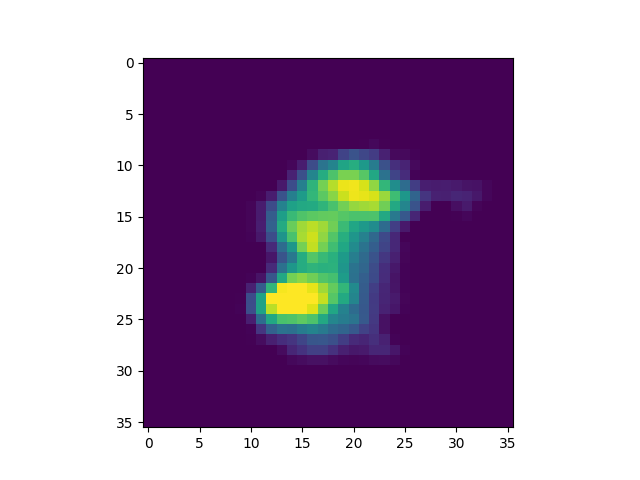

interactive(children=(IntSlider(value=0, description='i_frame', max=2637), Output()), _dom_classes=('widget-in…

In [43]:
%matplotlib notebook
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [44]:
roinet.generate_latents();

starting: running data through network


  0%|                                                   | 0/330 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int =

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggere

completed: running data through network


# draw selection

In [48]:
n_pcs_toKeep_nn = 40
n_pcs_toKeep_swt = 10

comp_nn, scores_nn, SVs, EVR_nn = roicat.helpers.torch_pca(roinet.latents, rank=n_pcs_toKeep_nn, zscore=False)
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)

In [49]:
from umap import UMAP
umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
emb_umap = umap.fit_transform(features_norm)
# emb_nn = umap.fit_transform(scores_nn)

In [50]:
embedding = emb_umap.copy()

In [51]:
## crappy heuristic for spreading out points

def get_spread_out_points(embeddings, thresh_dist=0.3, n_iter=3):
    import random
    import copy
    import sklearn
    from tqdm import tqdm

    def make_dist_mat(embeddings):
        dist_mat = sklearn.neighbors.NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None).fit(embeddings).kneighbors_graph(embeddings, n_neighbors=300, mode='distance').toarray()
        dist_mat[dist_mat==0.0] = np.nan
        return dist_mat

    def prune(dist_mat_pruned, thresh_dist, bool_good):
        idx_rand = np.random.permutation(np.arange(dist_mat_pruned.shape[0]))

        for idx in tqdm(idx_rand):
            if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:

                dist_mat_pruned[idx] = np.nan
                dist_mat_pruned[:,idx] = np.nan

                bool_good[idx] = False
        return dist_mat_pruned, bool_good

    def grow(dist_mat_pruned, dist_mat_raw, thresh_dist, bool_good):
        idx_good = np.nonzero(bool_good)[0]
        idx_bad = np.nonzero(~bool_good)[0]
        for idx in idx_bad:
            if np.nanmin(dist_mat_raw[idx][idx_good]) > thresh_dist:
                dist_mat_pruned[idx] = dist_mat_raw[idx]
                dist_mat_pruned[:,idx] = dist_mat_raw[:,idx]
                bool_good[idx] = True
        return dist_mat_pruned, bool_good

    dist_mat_raw = make_dist_mat(embeddings)

    n_sf = embeddings.shape[0]

    bool_good = np.ones(n_sf, dtype=np.bool8)
    
    dist_mat_pruned = copy.deepcopy(dist_mat_raw)
    
    for ii in range(n_iter):
        dist_mat_pruned, bool_good = prune(dist_mat_pruned, thresh_dist, bool_good)
        dist_mat_pruned, bool_good = grow(dist_mat_pruned, dist_mat_raw, thresh_dist, bool_good)
    dist_mat_pruned, bool_good = prune(dist_mat_pruned, thresh_dist, bool_good)

    return bool_good, dist_mat_pruned


In [52]:
bool_good, dist_mat_pruned = get_spread_out_points(emb_umap, thresh_dist=0.25, n_iter=3)
idx_good = np.nonzero(bool_good)[0]

  0%|                                                  | 0/2638 [00:00<?, ?it/s]/tmp/ipykernel_1726473/1799361002.py:18: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:
100%|████████████████████████████████████| 2638/2638 [00:00<00:00, 66869.98it/s]


In [53]:
import numpy as np

from matplotlib.widgets import LassoSelector
import matplotlib.path


class drawSelect_scatterplot:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, pts_y, pts_x, alpha_other=0.3, kwargs_scatter={}, callback=lambda x: None):
        self.pts_y = pts_y
        self.pts_x = pts_x
        
        self.ind_toInclude = np.arange(len(pts_y))
        self.alpha_other = alpha_other
        
        self.kwargs_scatter = kwargs_scatter
        
        self.callback = callback
        
    def scatter(self):
        self.fig, self.ax = plt.subplots()
        self.collection = self.ax.scatter(self.pts_y, self.pts_x, **self.kwargs_scatter)
        
        self.xys = self.collection.get_offsets()
        self.Npts = len(self.xys)
        
        self.canvas = self.ax.figure.canvas
        
        # Ensure that we have separate colors for each object
        self.fig.canvas.draw()
        self.fc = self.collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))
        
        self.lasso = LassoSelector(self.ax, onselect=self.onselect)
        self.ind = []
        
        self.callback(self.ax)
        
        return self.fig, self.ax
        
    def onselect(self, verts):
        path = matplotlib.path.Path(verts)
        self.ind = np.array(np.nonzero(path.contains_points(self.xys))[0])
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
        self.ax.clear()
        self.ax.scatter(self.pts_y, self.pts_x, c=[0.8, 0.8, 0.8], **self.kwargs_scatter)
        self.ax.scatter(self.pts_y[self.ind], self.pts_x[self.ind], c=[0,0,0], **self.kwargs_scatter)
        fig.canvas.draw()
        self.callback(self.ax)

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.canvas.draw_idle()

def plotMasks(selector , ax):
#     print(selector.ind)
    toInc = np.array(selector.ind_toInclude)[selector.ind]
    masks_all_selected = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
#     for ii in selector.ind:
    for ii in toInc:
        masks_all_selected[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] ] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_selected[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] ] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

    ax.imshow(masks_all_selected)

    print(f'Number of selected ROIs: {len(selector.ind)}')

<IPython.core.display.Javascript object>


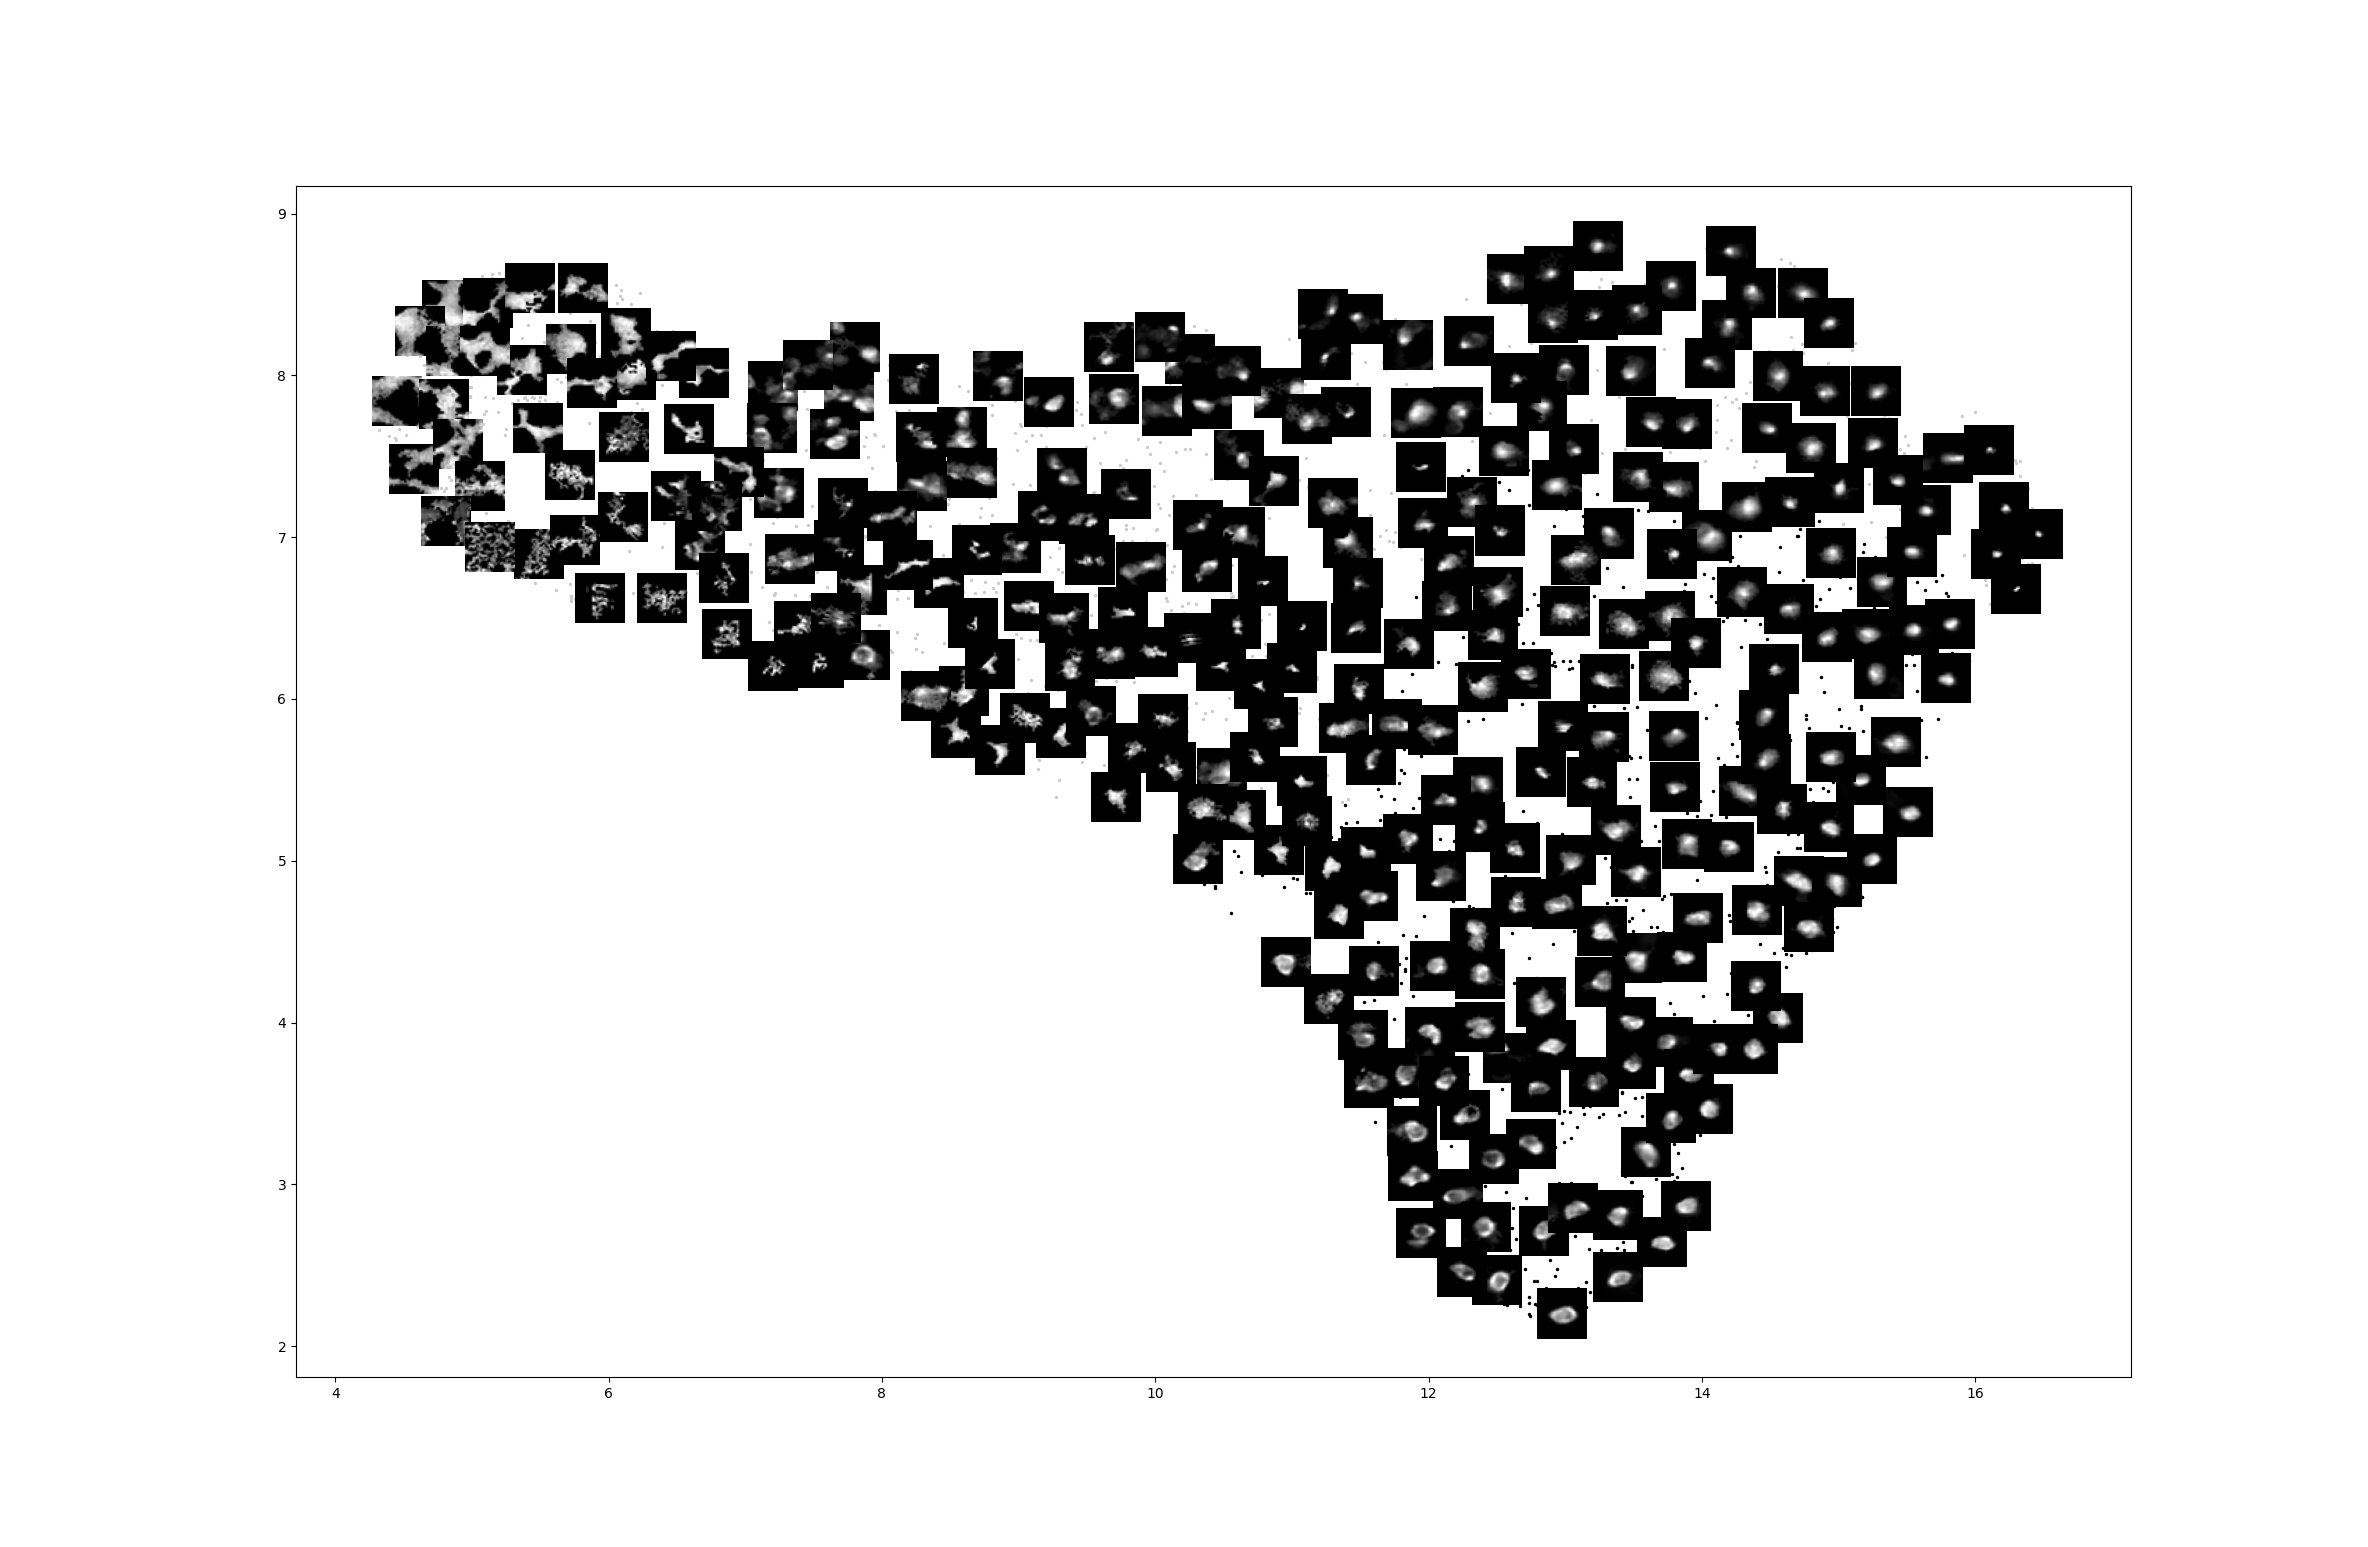

In [63]:
%matplotlib notebook

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


x, y, ims_subset = emb_umap[idx_good,0], emb_umap[idx_good,1], roinet.ROI_images_rs[idx_good]
def getImage(img):
    return OffsetImage(img, cmap='gray')
def callback_overlayIms(ax, x,y,imgs):
    for x0, y0, img in zip(x, y, ims_subset):
        ab = AnnotationBbox(getImage(img), (x0, y0), frameon=False)
        ax.add_artist(ab)
        
draw = drawSelect_scatterplot(emb_umap[:,0], emb_umap[:,1], alpha_other=0.3, kwargs_scatter={'s':2}, callback=partial(callback_overlayIms, x=x, y=y, imgs=ims_subset))
# draw = drawSelect_scatterplot(emb_umap[:,0], emb_umap[:,1], alpha_other=0.3, kwargs_scatter={'s':2},)
fig, ax = draw.scatter()

In [64]:
n_sessions = len(data.ROI_images)
idx_session_cat = np.concatenate([[ii]*data.ROI_images[ii].shape[0] for ii in range(n_sessions)])
bool_good_cat = roicat.helpers.idx2bool(draw.ind, length=len(idx_session_cat))
preds_good_sessions = [np.int64((bool_good_cat * (idx_session_cat==ii))[idx_session_cat==ii]) for ii in range(data.n_sessions)]

In [65]:
print(f"Number of 'good' and 'bad' ROIs from each session:")
print([f"good: {p.sum()} / bad: {(p!=1).sum()}" for p in preds_good_sessions])

Number of 'good' and 'bad' ROIs from each session:
['good: 1087 / bad: 1551']


<IPython.core.display.Javascript object>


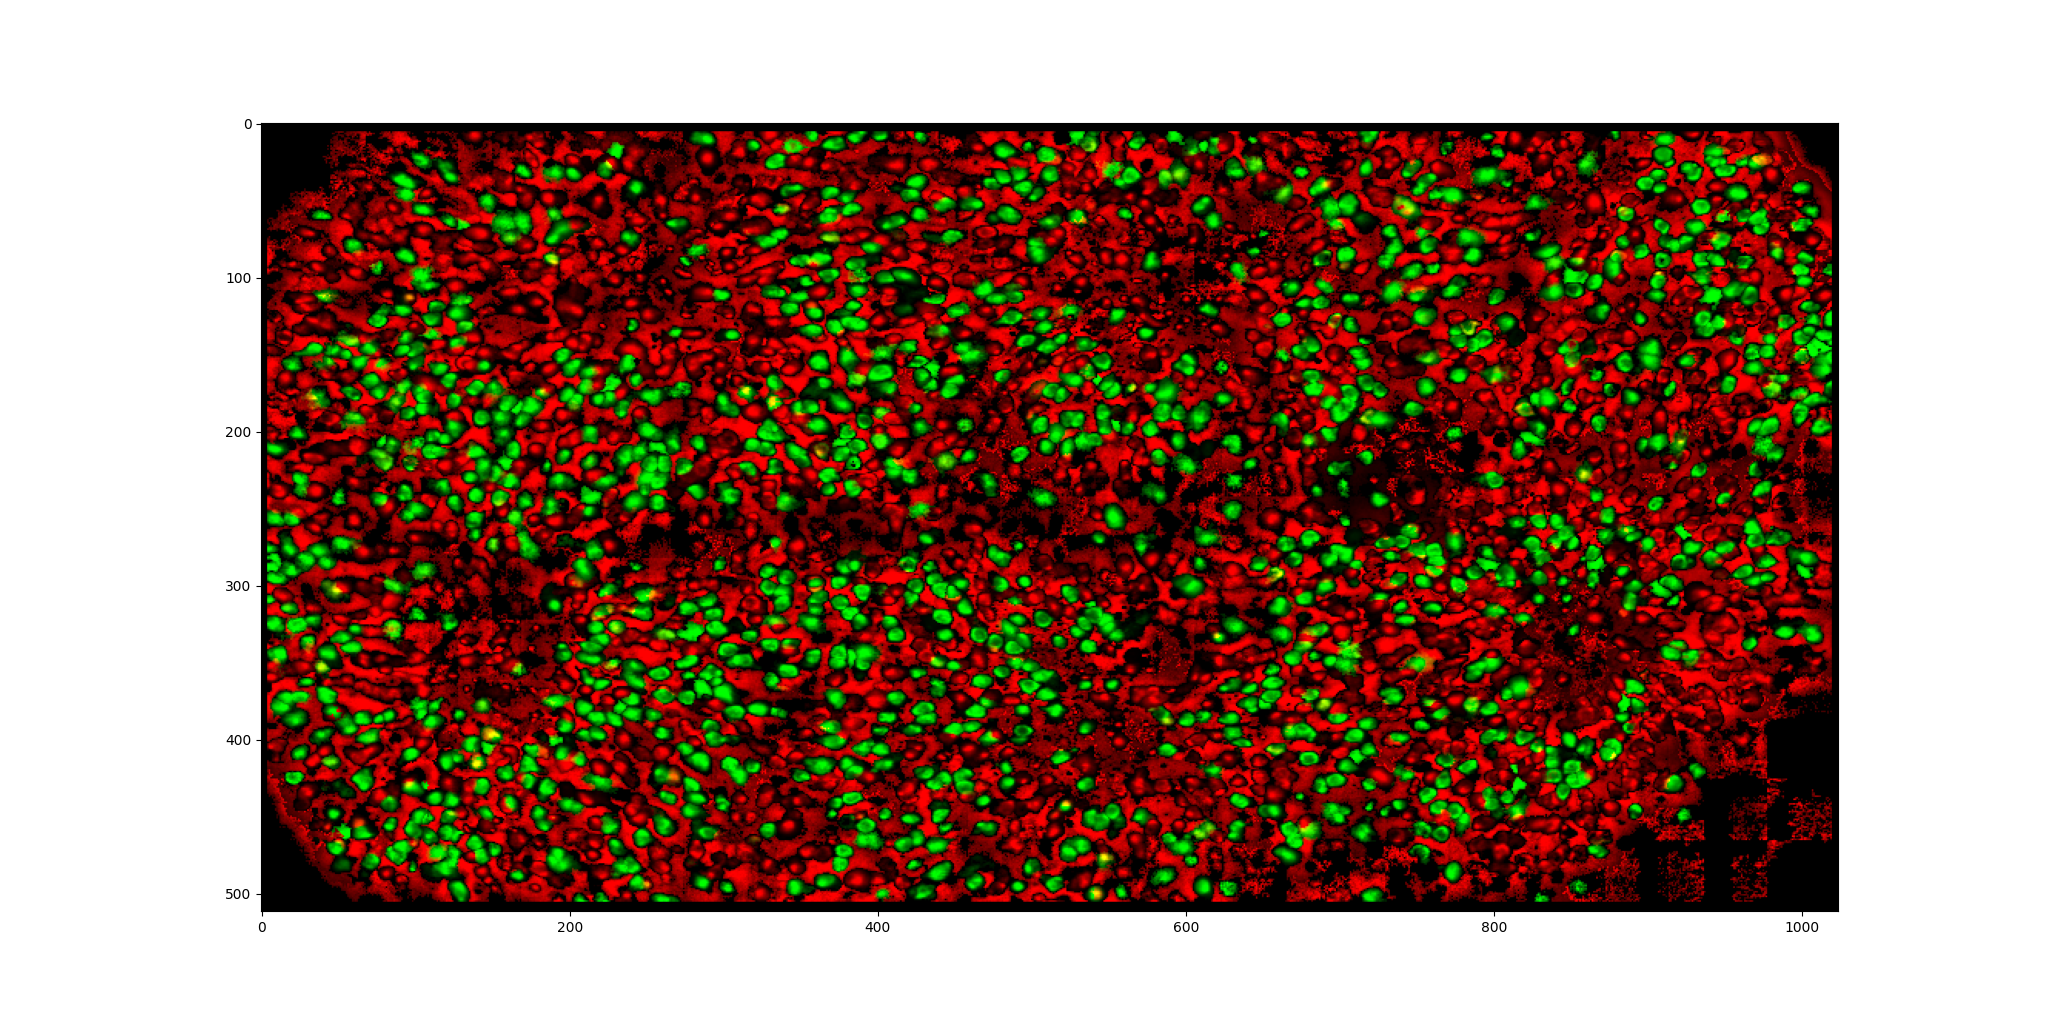

interactive(children=(IntSlider(value=0, description='i_frame', max=0), Output()), _dom_classes=('widget-inter…

In [66]:
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=data.spatialFootprints,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    labels=preds_good_sessions,
    cmap=roicat.helpers.simple_cmap([[1,0,0],[0,1,0]]),
)

fig, ax = plt.subplots(figsize=(data.FOV_width/50, data.FOV_height/50))
roicat.visualization.display_toggle_image_stack(FOVs_colored, fig=fig, ax=ax)

In [67]:
path_save = str(Path(dir_save).resolve() / (name_save + '.ROICaT.classification_drawn.results' + '.pkl'))
print(f'path_save: {path_save}')

path_save: /home/rich/Desktop/mouse_0315L.ROICaT.classification_drawn.results.pkl


In [68]:
classification_output = {
    'preds': preds_good_sessions,
    'spatialFootprints': data.spatialFootprints,
    'FOV_height': data.FOV_height,
    'FOV_width': data.FOV_width,
}

roicat.helpers.pickle_save(classification_output, str(Path(dir_save) / 'drawn_roi_classification_output.pkl'))